<a href="https://colab.research.google.com/github/JomarQr/Artificial-Intelligence-path/blob/main/Classification_Regression%20%2B%20Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task 1 (50)
1. Load the Data(synthetic 3D dataset csv), normalize, do train/test split, visualise
2. Build the Neural Network
Create a 3-layer neural network named  ClassifierNN class using PyTorch.
- Input Layer: Takes 3 features (x, y, z).
- Hidden Layers: Use ReLU activation and dropout.
- Output Layer: Outputs 3 values (one per class). No softmax needed (handled by loss function).
- Further add dropout layers to prevent overfitting and initialize weights properly.
3. Train the Model with:
Loss function: CrossEntropyLoss
Optimizer: Adam
Batch Size: Default is 32
In this task you should
 - implement the train_model() function.
 - track and print loss every 10 epochs.
- return a loss history to visualize training.
4. Evaluate the Model
- Implement evaluate_model() to calculate accuracy and test loss.
- Ensure predictions use argmax() to select the correct class.
- Print the final test accuracy and loss.
5. Tune Hyperparameters (test the model with different values of hyperparameters, find the best-performing model)
- Learning rates: 0.01, 0.001
- Batch sizes: 16, 32
- Hidden layer sizes: 32, 64
- Dropout rates: 0.2, 0.4
 6. Visualize Training Loss: Use Matplotlib to plot epochs vs. loss.



### **1. LOAD THE DATA**

In [48]:
from google.colab import files
uploaded = files.upload()

Saving synthetic_3d_dataset.csv to synthetic_3d_dataset (3).csv


In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [50]:
df = pd.read_csv('synthetic_3d_dataset.csv')

**View data**


In [51]:
print(df.head())

          x         y         z  label
0  2.351230  1.902232  2.457985      1
1  3.076945  1.834429  1.834440      1
2  3.116672  2.542658  1.668031      1
3  2.383648  1.672314  1.670679      1
4  2.171093  0.647107  0.780299      1


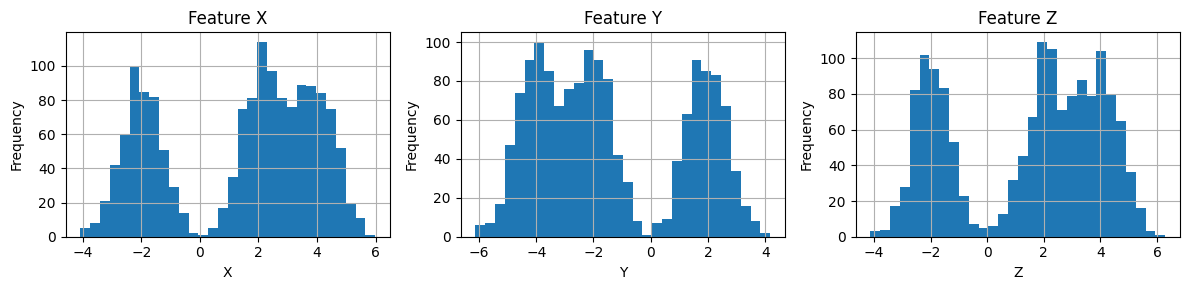

In [52]:
import matplotlib.pyplot as plt

feature_names = ['X', 'Y', 'Z']
fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # 1 row, 3 columns

for i in range(3):
    axes[i].hist(X[:, i], bins=30)
    axes[i].set_title(f'Feature {feature_names[i]}')
    axes[i].set_xlabel(feature_names[i])
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


**Not normally distributed** (no bell curve shape)

**Range vary:** X:[-4, 6] Y:[-6, 4] Z:[-4, 6]


In [53]:
for i in range(3):
    col = X[:, i]
    print(f"Feature {i} - Min: {col.min():.2f}, Max: {col.max():.2f}, Mean: {col.mean():.2f}, Std: {col.std():.2f}")


Feature 0 - Min: -4.08, Max: 5.99, Mean: 1.33, Std: 2.57
Feature 1 - Min: -6.13, Max: 4.18, Mean: -1.35, Std: 2.60
Feature 2 - Min: -4.14, Max: 6.29, Mean: 1.36, Std: 2.59


**No extreme outliers** (e.g. +-50)

In [42]:
import torch
import numpy as np

# Separate features and labels
X_np = df[['x', 'y', 'z']].values.astype(np.float32)
y_np = df['label'].values.astype(np.int64)

# Torch tensors
X = torch.tensor(X_np)
y = torch.tensor(y_np)

3D Scatter Plot

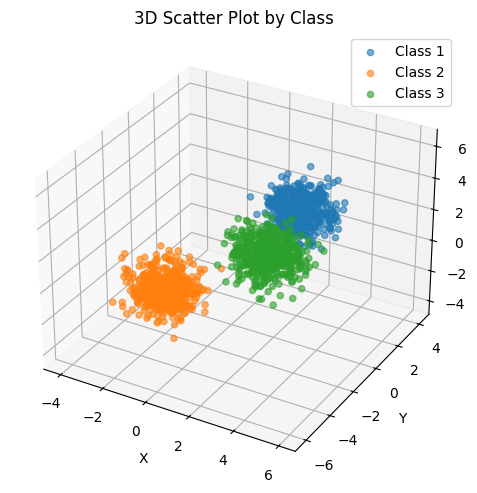

In [54]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(y):
    idx = y == label
    ax.scatter(X[idx, 0], X[idx, 1], X[idx, 2], label=f'Class {label}', alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot by Class')
plt.legend()
plt.tight_layout()
plt.show()

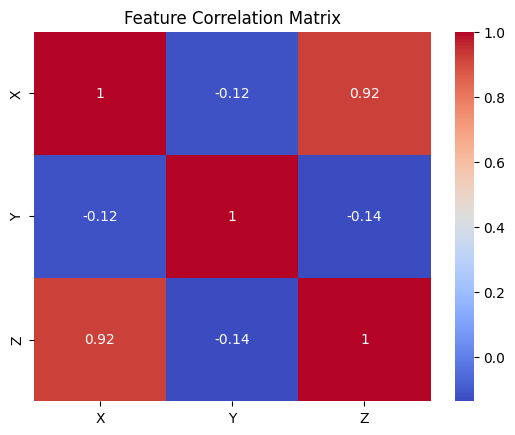

In [55]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(X, columns=['X', 'Y', 'Z'])
corr = df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

<ipython-input-56-a1ccfa3bf280>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X[:, 0], X[:, 1], X[:, 2]], labels=['X', 'Y', 'Z'])


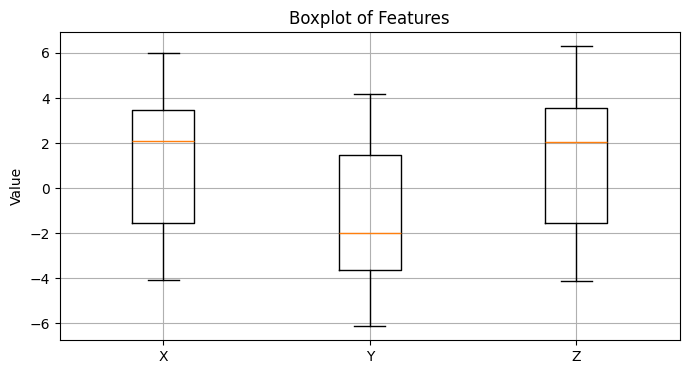

In [56]:
plt.figure(figsize=(8, 4))
plt.boxplot([X[:, 0], X[:, 1], X[:, 2]], labels=['X', 'Y', 'Z'])
plt.title("Boxplot of Features")
plt.ylabel("Value")
plt.grid(True)
plt.show()

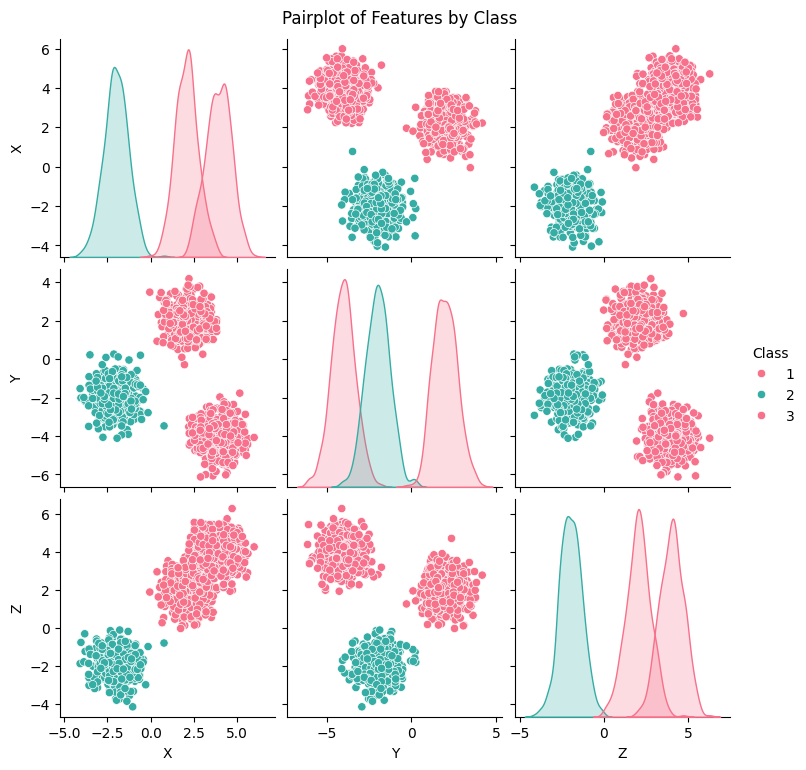

In [57]:
import seaborn as sns

df = pd.DataFrame(X, columns=['X', 'Y', 'Z'])
df['Class'] = y
sns.pairplot(df, hue='Class', palette='husl')
plt.suptitle("Pairplot of Features by Class", y=1.02)
plt.show()

In [58]:
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")

Class 1: 500 samples
Class 2: 500 samples
Class 3: 500 samples


**Normalize features**

In [59]:
# Min-max normalization
X_min = X.min(0, keepdim=True).values
X_max = X.max(0, keepdim=True).values
X_norm = (X - X_min) / (X_max - X_min)

1. Range: [0, 1] exactly
2. Sensitive to outliers
3. Distorts shape (linearly scales)
4. Using in Neural nets (especially if inputs are non-negative like images)

**Train/Test Split**

In [60]:
if isinstance(y, np.ndarray):
    y = torch.tensor(y, dtype=torch.long)

In [61]:
from torch.utils.data import TensorDataset, random_split

# Create a full dataset object
full_dataset = TensorDataset(X_norm, y)

# Calculate lengths
total_size = len(full_dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

# Split
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [62]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
sample_X, sample_y = train_dataset[0]
print("Sample input:", sample_X)
print("Sample label:", sample_y)

Sample input: tensor([0.7058, 0.7705, 0.7728])
Sample label: tensor(1)


**VISUALIZATION**

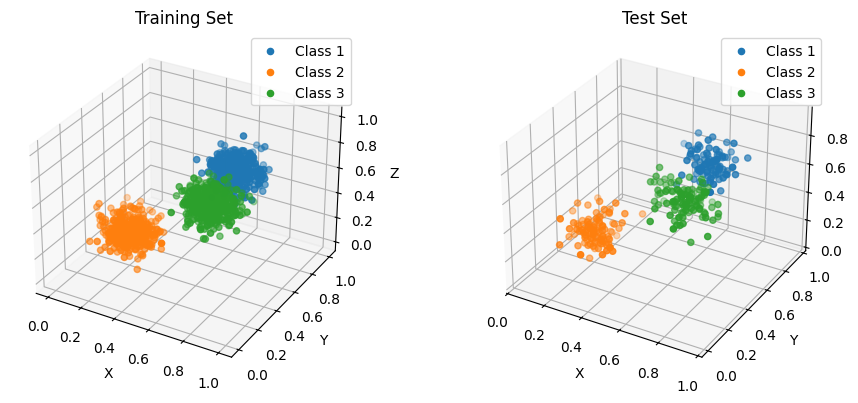

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert training and test tensors to NumPy arrays
X_train_np = train_dataset[:][0].numpy()
y_train_np = train_dataset[:][1].numpy()
X_test_np = test_dataset[:][0].numpy()
y_test_np = test_dataset[:][1].numpy()

# Create 3D plot
fig = plt.figure(figsize=(10, 4))

# Training data
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
for label in torch.unique(y):
    idx = y_train_np == label.item()
    ax1.scatter(X_train_np[idx, 0], X_train_np[idx, 1], X_train_np[idx, 2], label=f'Class {label.item()}')
ax1.set_title('Training Set')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Test data
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for label in torch.unique(y):
    idx = y_test_np == label.item()
    ax2.scatter(X_test_np[idx, 0], X_test_np[idx, 1], X_test_np[idx, 2], label=f'Class {label.item()}')
ax2.set_title('Test Set')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()

plt.tight_layout()
plt.show()


### **2. Build the Neural Network Create a 3-layer neural network named ClassifierNN class using PyTorch.**

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassifierNN(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, dropout_rate=0.3):
        super(ClassifierNN, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size, 3)  # 3 output classes

        # Initialize weights
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.output.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)  # No softmax here
        return x


In [67]:
from torch.utils.data import DataLoader

def train_model(model, train_dataset, num_epochs=100, learning_rate=0.001, batch_size=32):
    # Set model to training mode
    model.train()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.4f}")

    return loss_history


In [69]:
print(torch.unique(y))

tensor([1, 2, 3])


In [70]:
y = y - 1

In [71]:
full_dataset = TensorDataset(X_norm, y)

# Split again
total_size = len(full_dataset)
test_size = int(0.2 * total_size)
train_size = total_size - test_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


In [72]:
model = ClassifierNN(hidden_size=64, dropout_rate=0.3)
loss_history = train_model(model, train_dataset, num_epochs=100, learning_rate=0.001, batch_size=32)


Epoch 1/100 - Loss: 0.9499
Epoch 10/100 - Loss: 0.0324
Epoch 20/100 - Loss: 0.0073
Epoch 30/100 - Loss: 0.0080
Epoch 40/100 - Loss: 0.0032
Epoch 50/100 - Loss: 0.0027
Epoch 60/100 - Loss: 0.0011
Epoch 70/100 - Loss: 0.0037
Epoch 80/100 - Loss: 0.0006
Epoch 90/100 - Loss: 0.0032
Epoch 100/100 - Loss: 0.0051


In [73]:
def evaluate_model(model, test_dataset, batch_size=32):
    model.eval()  # Set model to evaluation mode
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    correct = 0
    total = 0
    total_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():  # No gradient tracking
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            total_loss += loss.item()

            # Get predicted class with highest score
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)

    print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {avg_loss:.4f}")
    return accuracy, avg_loss


In [74]:
evaluate_model(model, test_dataset, batch_size=32)

Test Accuracy: 1.0000, Test Loss: 0.0000


(1.0, 6.7354617158343896e-06)

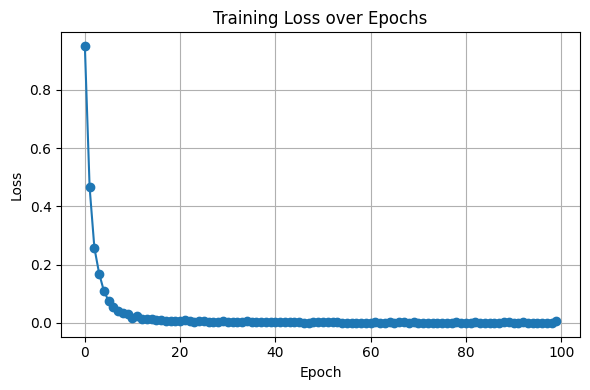

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(loss_history, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.**Train the Model with: Loss function: CrossEntropyLoss Optimizer: Adam Batch Size: Default is 32 In this task you shoul**

In [78]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

def train_model(model, train_dataset, num_epochs=100, learning_rate=0.001, batch_size=32):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0

        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.4f}")

    return loss_history


In [79]:
model = ClassifierNN(hidden_size=64, dropout_rate=0.3)
loss_history = train_model(model, train_dataset, num_epochs=100, learning_rate=0.001, batch_size=32)


Epoch 1/100 - Loss: 0.8666
Epoch 10/100 - Loss: 0.0128
Epoch 20/100 - Loss: 0.0039
Epoch 30/100 - Loss: 0.0050
Epoch 40/100 - Loss: 0.0021
Epoch 50/100 - Loss: 0.0022
Epoch 60/100 - Loss: 0.0010
Epoch 70/100 - Loss: 0.0015
Epoch 80/100 - Loss: 0.0007
Epoch 90/100 - Loss: 0.0032
Epoch 100/100 - Loss: 0.0003


### **4. Evaluate the Model**

In [80]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

def evaluate_model(model, test_dataset, batch_size=32):
    model.eval()  # Evaluation mode
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # No gradient computation
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            total_loss += loss.item()

            # Get predicted classes
            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == y_batch).sum().item()
            total_samples += y_batch.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total_samples

    print(f"Test Accuracy: {accuracy:.4f} | Test Loss: {avg_loss:.4f}")
    return accuracy, avg_loss


In [86]:
evaluate_model(model, test_dataset, batch_size=32)

Test Accuracy: 1.0000 | Test Loss: 0.0000


(1.0, 2.9857674405775468e-06)

### **5. Tune Hyperparameters (test the model with different values of hyperparameters, find the best-performing model)**

In [88]:
import itertools

# Hyperparameter options
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]
hidden_sizes = [32, 64]
dropout_rate = 0.3

best_acc = 0
best_config = {}
all_results = []

# Loop through all combinations
for lr, bs, hs in itertools.product(learning_rates, batch_sizes, hidden_sizes):
    print(f"\nTraining with LR={lr}, Batch Size={bs}, Hidden Size={hs}")


    model = ClassifierNN(hidden_size=hs, dropout_rate=dropout_rate)
    loss_history = train_model(model, train_dataset, num_epochs=100, learning_rate=lr, batch_size=bs)
    acc, loss = evaluate_model(model, test_dataset, batch_size=bs)
    config = {'lr': lr, 'batch_size': bs, 'hidden_size': hs, 'accuracy': acc, 'loss': loss}
    all_results.append(config)

    if acc > best_acc:
        best_acc = acc
        best_config = config

print("\nBest Hyperparameter Configuration:")
print(best_config)



Training with LR=0.01, Batch Size=16, Hidden Size=32
Epoch 1/100 - Loss: 0.3338
Epoch 10/100 - Loss: 0.0045
Epoch 20/100 - Loss: 0.0129
Epoch 30/100 - Loss: 0.0025
Epoch 40/100 - Loss: 0.0147
Epoch 50/100 - Loss: 0.0008
Epoch 60/100 - Loss: 0.0003
Epoch 70/100 - Loss: 0.0017
Epoch 80/100 - Loss: 0.0001
Epoch 90/100 - Loss: 0.0022
Epoch 100/100 - Loss: 0.0000
Test Accuracy: 1.0000 | Test Loss: 0.0000

Training with LR=0.01, Batch Size=16, Hidden Size=64
Epoch 1/100 - Loss: 0.1877
Epoch 10/100 - Loss: 0.0005
Epoch 20/100 - Loss: 0.0018
Epoch 30/100 - Loss: 0.0005
Epoch 40/100 - Loss: 0.0346
Epoch 50/100 - Loss: 0.0022
Epoch 60/100 - Loss: 0.0009
Epoch 70/100 - Loss: 0.0035
Epoch 80/100 - Loss: 0.0002
Epoch 90/100 - Loss: 0.0017
Epoch 100/100 - Loss: 0.0000
Test Accuracy: 1.0000 | Test Loss: 0.0000

Training with LR=0.01, Batch Size=32, Hidden Size=32
Epoch 1/100 - Loss: 0.5236
Epoch 10/100 - Loss: 0.0160
Epoch 20/100 - Loss: 0.0042
Epoch 30/100 - Loss: 0.0047
Epoch 40/100 - Loss: 0.0021

### **6.Visualize Training Loss: Use Matplotlib to plot epochs vs. loss.**

In [89]:
import matplotlib.pyplot as plt

def plot_loss(loss_history):
    plt.figure(figsize=(6, 4))
    plt.plot(loss_history, marker='o')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1/100 - Loss: 0.9632
Epoch 10/100 - Loss: 0.0176
Epoch 20/100 - Loss: 0.0074
Epoch 30/100 - Loss: 0.0053
Epoch 40/100 - Loss: 0.0022
Epoch 50/100 - Loss: 0.0012
Epoch 60/100 - Loss: 0.0006
Epoch 70/100 - Loss: 0.0004
Epoch 80/100 - Loss: 0.0010
Epoch 90/100 - Loss: 0.0008
Epoch 100/100 - Loss: 0.0008


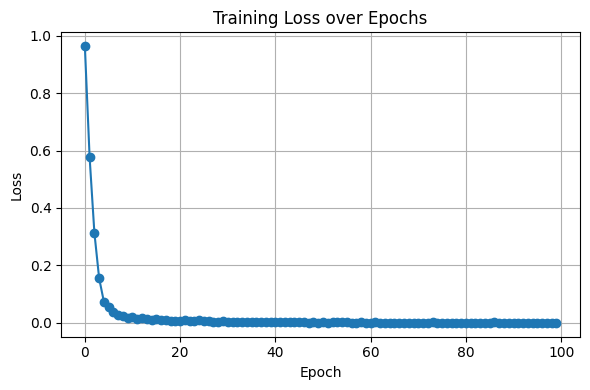

In [90]:
model = ClassifierNN(hidden_size=64, dropout_rate=0.3)
loss_history = train_model(model, train_dataset, num_epochs=100, learning_rate=0.001, batch_size=32)
plot_loss(loss_history)

### 2. Task 2 (50)
Improve the performance of those Keplar-stellar regression models given your new knowledge: regularization techniques, learning reate schedulers, etc. All the necessary functions are implemented in pytorch and can be found in documentation.

Think of the fact that the dataset is imbalanced try to apply some of the techniques mentioned in the article.

## **Regulation Techniques**

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

## **1: Simulated Data (replace with actual Kepler dataset)**

In [101]:
torch.manual_seed(0)
X = torch.randn(1000, 13)  # 13 input features
y = torch.randn(1000)

## **2: Split into training and validation**




In [102]:
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## **3: Model with Dropout Regularization**

In [103]:
class KeplerRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.out = nn.Linear(64, 1)

        # Weight Initialization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.out.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.out(x)

## **4: Custom Weighted Loss to Handle Imbalance**

In [104]:
def weighted_mse(pred, target):
    weights = 1 + torch.abs(target)
    return torch.mean(weights * (pred.view(-1) - target) ** 2)

## **5: Training Setup with Regularization + LR Scheduler**

In [105]:
model = KeplerRegressionModel()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 Regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
loss_fn = weighted_mse

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## **6: Training with Early Stopping**

In [106]:
num_epochs = 100
patience = 10
best_val_loss = float('inf')
counter = 0
loss_history = []

In [107]:
for epoch in range(1, num_epochs + 1):
    model.train()
    total_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_pred = model(X_val).squeeze()
            loss = loss_fn(val_pred, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    loss_history.append(avg_val_loss)

    print(f"Epoch {epoch:03d}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)
            break

Epoch 001: Train Loss = 6.2154 | Val Loss = 2.5938
Epoch 002: Train Loss = 5.2999 | Val Loss = 2.4948
Epoch 003: Train Loss = 4.1955 | Val Loss = 2.4641
Epoch 004: Train Loss = 3.6124 | Val Loss = 2.4685
Epoch 005: Train Loss = 3.5462 | Val Loss = 2.4477
Epoch 006: Train Loss = 3.6358 | Val Loss = 2.3909
Epoch 007: Train Loss = 3.1869 | Val Loss = 2.3661
Epoch 008: Train Loss = 3.3634 | Val Loss = 2.3835
Epoch 009: Train Loss = 3.2354 | Val Loss = 2.3741
Epoch 010: Train Loss = 3.0124 | Val Loss = 2.3511
Epoch 011: Train Loss = 3.1049 | Val Loss = 2.3406
Epoch 012: Train Loss = 3.0177 | Val Loss = 2.3496
Epoch 013: Train Loss = 2.8243 | Val Loss = 2.3138
Epoch 014: Train Loss = 2.8105 | Val Loss = 2.3173
Epoch 015: Train Loss = 2.7577 | Val Loss = 2.3319
Epoch 016: Train Loss = 2.7707 | Val Loss = 2.3382
Epoch 017: Train Loss = 2.7541 | Val Loss = 2.3431
Epoch 018: Train Loss = 2.8125 | Val Loss = 2.3257
Epoch 019: Train Loss = 2.6334 | Val Loss = 2.3529
Epoch 020: Train Loss = 2.7719 

## **7: Plot the Validation Loss**

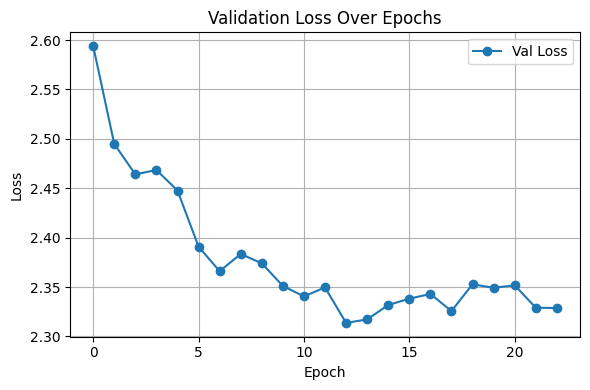

In [108]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history, label='Val Loss', marker='o')
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Compared to the previous model, this training run demonstrates a smoother and more stable decrease in validation loss. the minimum validation loss is slightly lower (~2.31 vs ~2.33), and the plateau occurs later in training, suggesting that the model continued learning for more epochs. The reduced fluctuation indicates better regularization or improved hyperparameter tuning. Overall, this result shows a small but meaningfull improvements in model generalization performance